# Processing Data 

In this jupyter what we are looking for is to be able to process the data to obtain a prediction for days 1, 3 and 7.

In summary, first we will extract the sentiment of the tweets and then we will make a union of the two tables tweets and prices. We will use the Arimax Model and LSTM to get the predictions when the data is ready.

## Libraries for processing 

In [1]:
# Process Data
from pyspark.sql import SparkSession  # Spark Session
from pyspark.sql.functions import lit, col, sum, length, regexp_replace, explode, udf
from pyspark.sql.types import FloatType, StringType
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import to_date


In [2]:
# EDA
from wordcloud import WordCloud
import re
import emoji
import string

# Sentiment
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Graphs
import matplotlib.pyplot as plt
import seaborn as sns

# General
import pandas as pd
import numpy as np

# Prediction
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Cassandra
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider


2024-12-11 20:35:33.131845: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-11 20:35:33.134757: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-11 20:35:33.143604: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733949333.158240   91931 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733949333.162661   91931 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 20:35:33.177614: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

### Using Spark with Hive

Create a Spark session to connect to the hive database

In [4]:
# Configuration before creating the Spark session
spark = SparkSession.builder \
    .appName("StockTweetsToHive") \
    .enableHiveSupport() \
    .getOrCreate()

24/12/11 20:35:35 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


## Reading the data from Hive

We look for our previously created database

In [5]:
spark.sql("Show databases;").show()

+---------+
|namespace|
+---------+
|benchmark|
|      ca2|
|  default|
| testhive|
+---------+



We look for our previously created database

In [6]:
spark.sql("USE ca2;")

DataFrame[]

We load our tweets in a spark dataframe we load tweets 

In [7]:
tweets = spark.sql("Select * from tweets;")

In [8]:
tweets.show()
print(tweets.count())

+------+----------+------+--------------------+
|    id|      date|ticker|               tweet|
+------+----------+------+--------------------+
|100001|01/01/2020|  AMZN|$AMZN Dow futures...|
|100002|01/01/2020|  TSLA|$TSLA Daddy's dri...|
|100003|01/01/2020|  AAPL|$AAPL We’ll been ...|
|100004|01/01/2020|  TSLA|$TSLA happy new y...|
|100005|01/01/2020|  TSLA|"$TSLA haha just ...|
|100006|01/01/2020|  TSLA|$TSLA NOBODY: Gas...|
|100007|02/01/2020|  AAPL|$AAPL $300 calls ...|
|100008|02/01/2020|  AAPL|$AAPL Remember, i...|
|100009|02/01/2020|  AAPL|$AAPL called it, ...|
|100010|02/01/2020|    HD|$HD Bought more a...|
|100011|02/01/2020|  AAPL|Apple is taking t...|
|100012|02/01/2020|  AAPL|$AAPL not a bad d...|
|100013|02/01/2020|  AAPL|$AAPL where are a...|
|100014|03/01/2020|  NVDA|$NVDA This should...|
|100015|03/01/2020|  AAPL|$AAPL tomorrow bu...|
|100016|03/01/2020|  AAPL|$AAPL Thanks for ...|
|100017|03/01/2020|  AAPL|$AAPL leave enoug...|
|100018|03/01/2020|  AAPL|$AAPL short th

# EDA from tweets

## 1.- Initial display and basic description

We get only the tweets of the companies we are interested in, we have taken companies in ramdon mode.

Now let's filter and see a general description of the tweets table. 

In [9]:
# Filtrar el dataframe para las 5 compañías
tickers = ["BAC", "DIS", "PG", "TSLA", "WMT"]
tweets = tweets.filter(tweets['ticker'].isin(tickers))

In [10]:
# Show the firsts rows 
tweets.select('tweet').show(10)

# get statistic descriptive 
tweets.select('tweet').describe().show()

+--------------------+
|               tweet|
+--------------------+
|$TSLA Daddy's dri...|
|$TSLA happy new y...|
|"$TSLA haha just ...|
|$TSLA NOBODY: Gas...|
|$TSLA  I must ris...|
|$TSLA shorts are ...|
|$TSLA Don’t short...|
|$TSLA 🐻 not see ...|
|$TSLA  can one he...|
|$TSLA Ignore the ...|
+--------------------+
only showing top 10 rows

+-------+--------------------+
|summary|               tweet|
+-------+--------------------+
|  count|                4959|
|   mean|                null|
| stddev|                null|
|    min| Bummer that $TSL...|
|    max|🚨🔥☆☆☆ $TSLA ☆☆☆...|
+-------+--------------------+



## 2.- Review of null or empty values

We check for null values, in this case there are no null values.

In [11]:
# Count null or empty values in the column 'tweet'.
tweets.filter(tweets['tweet'].isNull()).count()
tweets.filter(tweets['tweet'] == '').count()


0

## 3.- Length of tweets

In [12]:
# Calculate the length of the tweets
df_with_length_filtered = tweets.withColumn("tweet_length", length(tweets['tweet']))

# Statistics on the length of the tweets
df_with_length_filtered.select('tweet_length').describe().show()

# Show tweets with extreme length
df_with_length_filtered.filter(df_with_length_filtered['tweet_length'] > 200).show(10)  # Example for tweets longer than 200 characters


+-------+-----------------+
|summary|     tweet_length|
+-------+-----------------+
|  count|             4959|
|   mean|81.52046783625731|
| stddev|46.21096124505679|
|    min|               23|
|    max|              255|
+-------+-----------------+

+------+----------+------+--------------------+------------+
|    id|      date|ticker|               tweet|tweet_length|
+------+----------+------+--------------------+------------+
|100047|07/01/2020|  TSLA|$TSLA bears 🐻 I ...|         235|
|100064|08/01/2020|   DIS|$DIS small piece ...|         237|
|100250|22/01/2020|  TSLA|$TSLA y’all need ...|         223|
|100279|23/01/2020|  TSLA|$TSLA If someone ...|         224|
|100308|24/01/2020|  TSLA|$TSLA lol its so ...|         237|
|100322|28/01/2020|  TSLA|$TSLA there'san e...|         234|
|100473|03/02/2020|  TSLA|$TSLA Unbelievabl...|         222|
|100594|06/02/2020|  TSLA|$TSLA i am going ...|         244|
|100733|13/02/2020|  TSLA|$TSLA i freaking ...|         215|
|100874|24/02/20

## 4.- Word frequency

We will show the most frequently occurring words in all tweets in order to explore the data in a general way.

In [13]:
from pyspark.sql.functions import regexp_replace, split, explode

# Clean the tweets (remove non-alphanumeric characters) and split into words
df_cleaned = tweets.withColumn("cleaned_tweet", regexp_replace("tweet", "[^a-zA-Z\\s]", ""))
df_tokenized = df_cleaned.withColumn("words", split(col("cleaned_tweet"), "\\s+"))

# Exploding the words and counting occurrences
word_count = df_tokenized.withColumn("word", explode(df_tokenized['words'])) \
                         .groupBy("word").count() \
                         .orderBy(col('count').desc())

# Show the top 10 most frequent words
word_count.show(10)


+----+-----+
|word|count|
+----+-----+
|TSLA| 4395|
|    | 3463|
| the| 1927|
|  to| 1769|
|   a| 1172|
|this|  997|
|  is|  956|
| and|  930|
|   I|  881|
|  in|  723|
+----+-----+
only showing top 10 rows



## 5.- Word cloud 

We only show interactively the words that appear more in tweets according to frequency

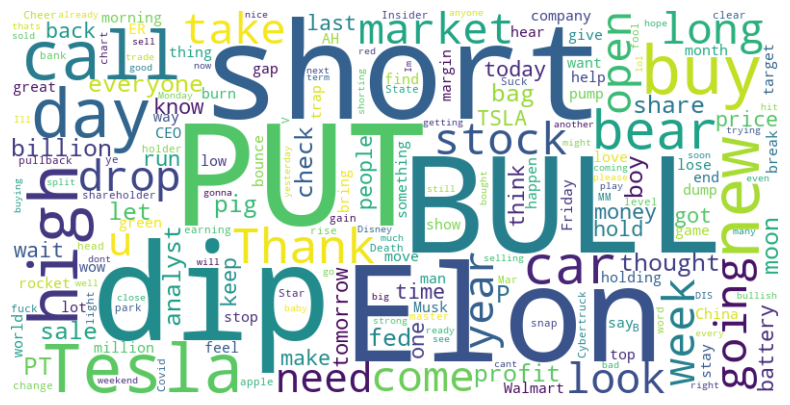

In [14]:
# Get the most frequent words for the 5 companies
#words_filtered = word_count_filtered.toPandas()
words_filtered = word_count.toPandas()
words_str_filtered = ' '.join(words_filtered['word'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(words_str_filtered)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


## 6.- Text cleaning

We have created a function to clean up the text we pass to it, and we have specified the type of cleaning for informal text 

In [15]:
# Function to clean text
def clean_text(tweet):
    # Remove emojis
    tweet = emoji.replace_emoji(tweet, replace='')  # Removes the emojis

    # Remove user mentions (words that start with '@')
    tweet = re.sub(r'@\w+', '', tweet)

    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+', '', tweet)

    # Remove hashtags (if you don't want to keep the hashtags)
    tweet = re.sub(r'#\w+', '', tweet)

    # Remove punctuation
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers (if they are not relevant for the analysis)
    tweet = re.sub(r'\d+', '', tweet)

    # Convert to lowercase
    tweet = tweet.lower()

    # Remove extra spaces
    tweet = re.sub(r'\s+', ' ', tweet).strip()

    return tweet

# Convert the function into a UDF for PySpark
clean_text_udf = udf(clean_text, StringType())


We call the function to clean and display the original text and the cleaned text.

In [16]:
# Remove mentions (@user) and links (http://...)
df_cleaned = tweets.withColumn("cleaned_tweet", clean_text_udf(tweets['tweet']))

# Show cleaned tweets
df_cleaned.select('tweet','cleaned_tweet').show(20)


+--------------------+--------------------+
|               tweet|       cleaned_tweet|
+--------------------+--------------------+
|$TSLA Daddy's dri...|tsla daddys drink...|
|$TSLA happy new y...|tsla happy new ye...|
|"$TSLA haha just ...|tsla haha just a ...|
|$TSLA NOBODY: Gas...|tsla nobody gas c...|
|$TSLA  I must ris...|tsla i must rise ...|
|$TSLA shorts are ...|tsla shorts are f...|
|$TSLA Don’t short...|tsla don’t short ...|
|$TSLA 🐻 not see ...|tsla not see anyt...|
|$TSLA  can one he...|tsla can one hear...|
|$TSLA Ignore the ...|tsla ignore the c...|
|$TSLA  Squeal lik...|tsla squeal like ...|
|$TSLA shorts thou...|tsla shorts thoug...|
|$TSLA if you had ...|tsla if you had o...|
|Once again $TSLA ...|once again tsla k...|
|$TSLA BUT BUTT WW...|tsla but butt ww ...|
|$TSLA Congratulat...|tsla congratulati...|
|$TSLA these bears...|tsla these bears ...|
|$TSLA Top of the ...|tsla top of the c...|
|$TSLA wow jpm wit...|tsla wow jpm with...|
|$DIS Just keep fa...|dis just ke

# Sentiment analysis for Tweets

To make the sentiment we have implemented 2 options, one using the TextBlob library and the other one using Vader as follows

### Implementation Textblob

In [17]:
# Function to analyze sentiment using TextBlob
def analyze_sentiment(text):
    try:
        blob = TextBlob(text)
        # Polarity: -1 (negative) to 1 (positive)
        return blob.sentiment.polarity
    except Exception as e:
        return None

# Create a UDF (User Defined Function) in PySpark to apply sentiment analysis
sentiment_udf = udf(analyze_sentiment, FloatType())

# Apply sentiment analysis on the 'tweet' column for the 5 companies
df_sentiment = df_cleaned.withColumn('sentiment', sentiment_udf(df_cleaned['tweet']))

# Show the first rows with the calculated sentiment
df_sentiment.select('tweet', 'sentiment').show(10)


+--------------------+----------+
|               tweet| sentiment|
+--------------------+----------+
|$TSLA Daddy's dri...|   0.15625|
|$TSLA happy new y...|0.46818182|
|"$TSLA haha just ...|       0.5|
|$TSLA NOBODY: Gas...|      -0.2|
|$TSLA  I must ris...|       0.5|
|$TSLA shorts are ...|       0.0|
|$TSLA Don’t short...|       0.4|
|$TSLA 🐻 not see ...|      0.05|
|$TSLA  can one he...|       0.0|
|$TSLA Ignore the ...|       1.0|
+--------------------+----------+
only showing top 10 rows



### Implementation Vader

In [18]:
# Initialize the VADER analyzer
analyzer = SentimentIntensityAnalyzer()

In [19]:
# Function to calculate sentiment using VADER
def get_sentiment(tweet):
    sentiment_score = analyzer.polarity_scores(tweet)
    return sentiment_score['compound']  # The 'compound' key is the overall polarity

# Convert the function into a PySpark UDF
sentiment_udf = udf(get_sentiment, FloatType())

In [20]:
# Apply sentiment analysis to the 'tweet' column
df_sentiment = tweets.withColumn("sentiment", sentiment_udf(tweets['tweet']))

# Show the first results with the calculated sentiment
df_sentiment.select('tweet', 'sentiment').show(10)


+--------------------+---------+
|               tweet|sentiment|
+--------------------+---------+
|$TSLA Daddy's dri...|      0.0|
|$TSLA happy new y...|   0.7506|
|"$TSLA haha just ...|   0.9371|
|$TSLA NOBODY: Gas...|  -0.9588|
|$TSLA  I must ris...|   0.9876|
|$TSLA shorts are ...|  -0.4939|
|$TSLA Don’t short...|   0.5267|
|$TSLA 🐻 not see ...|  -0.2755|
|$TSLA  can one he...|   0.7184|
|$TSLA Ignore the ...|   0.7256|
+--------------------+---------+
only showing top 10 rows



I choosen Vader, because is more for informal text. Also I have checked manually some text and for sure Vader es Better than TextBlob for tweets

### Categorizate 

Now for a better representation of the values we will create a sentiment category column to show textually the sentiment of the tweet.

In [21]:
# Function to categorize sentiment
def sentiment_category(polarity):
    if polarity > 0:
        return "positive"
    elif polarity < 0:
        return "negative"
    else:
        return "neutral"

# Create a UDF to apply the categorization
sentiment_category_udf = udf(sentiment_category, StringType())

# Add the column with the sentiment category
df_sentiment_with_category = df_sentiment.withColumn('sentiment_category', sentiment_category_udf(df_sentiment['sentiment']))

# Show the first rows with the sentiment category
df_sentiment_with_category.select('tweet', 'sentiment', 'sentiment_category').show(10)


+--------------------+---------+------------------+
|               tweet|sentiment|sentiment_category|
+--------------------+---------+------------------+
|$TSLA Daddy's dri...|      0.0|           neutral|
|$TSLA happy new y...|   0.7506|          positive|
|"$TSLA haha just ...|   0.9371|          positive|
|$TSLA NOBODY: Gas...|  -0.9588|          negative|
|$TSLA  I must ris...|   0.9876|          positive|
|$TSLA shorts are ...|  -0.4939|          negative|
|$TSLA Don’t short...|   0.5267|          positive|
|$TSLA 🐻 not see ...|  -0.2755|          negative|
|$TSLA  can one he...|   0.7184|          positive|
|$TSLA Ignore the ...|   0.7256|          positive|
+--------------------+---------+------------------+
only showing top 10 rows



### Length distribution of tweets (Visualization)

I will now show the distributions of the distribution categories by company in a table.

In [22]:
# Group by 'ticker' and calculate the average of 'sentiment' and the count of each sentiment category
sentiment_stats = df_sentiment_with_category.groupBy('ticker', 'sentiment_category') \
    .count() \
    .orderBy('ticker', 'sentiment_category')

# Show sentiment statistics by ticker
sentiment_stats.show()


+------+------------------+-----+
|ticker|sentiment_category|count|
+------+------------------+-----+
|   BAC|          negative|   15|
|   BAC|           neutral|   19|
|   BAC|          positive|   31|
|   DIS|          negative|  103|
|   DIS|           neutral|   89|
|   DIS|          positive|  240|
|    PG|          negative|    2|
|    PG|          positive|    1|
|  TSLA|          negative|  817|
|  TSLA|           neutral|  856|
|  TSLA|          positive| 2668|
|   WMT|          negative|   27|
|   WMT|           neutral|   27|
|   WMT|          positive|   64|
+------+------------------+-----+



I will now plot the table to better visualize the distributions of sentiments 

In [23]:
def show_distribution_tweets(data, title): 
    # Convert the Spark dataframe to pandas for plotting
    #pandas_df_sentiment = df_sentiment_with_category.toPandas()
    pandas_df_sentiment = data
    
    # Plot the distribution of sentiments by ticker
    plt.figure(figsize=(10, 6))
    sns.countplot(x='ticker', hue='sentiment_category', data=pandas_df_sentiment)
    plt.title(title)
    plt.xlabel("Companies")
    plt.ylabel("Number of Tweets")
    plt.show()


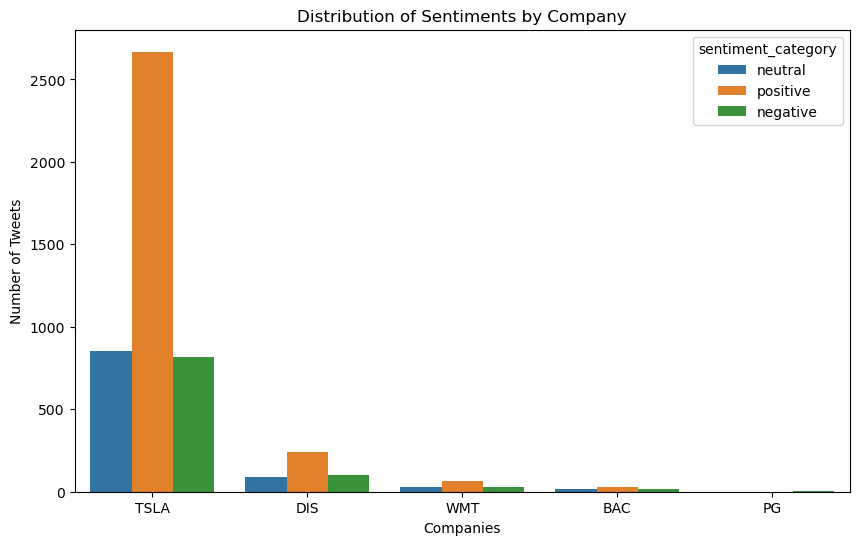

In [24]:
show_distribution_tweets(df_sentiment_with_category.toPandas(), "Distribution of Sentiments by Company")

# Processing Tweets

While we have seen the sentiment for each category in each company, we have to check if there may be tweets on the same date, and if that is the case we should average the tweets of the day to place a single sentiment per day.

In [25]:
df_sentiment_with_category.select('*').show(10)

+------+----------+------+--------------------+---------+------------------+
|    id|      date|ticker|               tweet|sentiment|sentiment_category|
+------+----------+------+--------------------+---------+------------------+
|100002|01/01/2020|  TSLA|$TSLA Daddy's dri...|      0.0|           neutral|
|100004|01/01/2020|  TSLA|$TSLA happy new y...|   0.7506|          positive|
|100005|01/01/2020|  TSLA|"$TSLA haha just ...|   0.9371|          positive|
|100006|01/01/2020|  TSLA|$TSLA NOBODY: Gas...|  -0.9588|          negative|
|100019|03/01/2020|  TSLA|$TSLA  I must ris...|   0.9876|          positive|
|100020|03/01/2020|  TSLA|$TSLA shorts are ...|  -0.4939|          negative|
|100021|03/01/2020|  TSLA|$TSLA Don’t short...|   0.5267|          positive|
|100023|03/01/2020|  TSLA|$TSLA 🐻 not see ...|  -0.2755|          negative|
|100024|03/01/2020|  TSLA|$TSLA  can one he...|   0.7184|          positive|
|100025|03/01/2020|  TSLA|$TSLA Ignore the ...|   0.7256|          positive|


Selecting only important columns


In [26]:
df_setiment_final = df_sentiment_with_category.select('date', 'ticker', 'sentiment','sentiment_category')
df_setiment_final.show(5)
print(df_sentiment.count())

+----------+------+---------+------------------+
|      date|ticker|sentiment|sentiment_category|
+----------+------+---------+------------------+
|01/01/2020|  TSLA|      0.0|           neutral|
|01/01/2020|  TSLA|   0.7506|          positive|
|01/01/2020|  TSLA|   0.9371|          positive|
|01/01/2020|  TSLA|  -0.9588|          negative|
|03/01/2020|  TSLA|   0.9876|          positive|
+----------+------+---------+------------------+
only showing top 5 rows

4959


Grouping register with the same date and company

In [27]:
# Group by 'date' and 'ticker' and calculate the average sentiment.
df_sentiment_avg = df_setiment_final.groupBy('date', 'ticker') \
    .agg(
        F.avg('sentiment').alias('sentiment')
    )

df_sentiment_avg.show(5)


+----------+------+------------------+
|      date|ticker|         sentiment|
+----------+------+------------------+
|24/01/2020|  TSLA|0.2638999968767166|
|03/02/2020|  TSLA|0.4597533330321312|
|31/03/2020|   WMT|             0.875|
|01/07/2020|  TSLA| 0.248860003054142|
|03/11/2020|   WMT| 0.769599974155426|
+----------+------+------------------+
only showing top 5 rows



In [28]:
# Classify the sentiment based on the average value
df_sentiment_final = df_sentiment_avg.withColumn(
    'sentiment_category',
    F.when(df_sentiment_avg['sentiment'] > 0, 'Positive')
    .when(df_sentiment_avg['sentiment'] < 0, 'Negative')
    .otherwise('Neutral')
)

# Show the result
df_sentiment_final.show(5)
print(df_sentiment_final.count())


+----------+------+------------------+------------------+
|      date|ticker|         sentiment|sentiment_category|
+----------+------+------------------+------------------+
|24/01/2020|  TSLA|0.2638999968767166|          Positive|
|03/02/2020|  TSLA|0.4597533330321312|          Positive|
|31/03/2020|   WMT|             0.875|          Positive|
|01/07/2020|  TSLA| 0.248860003054142|          Positive|
|03/11/2020|   WMT| 0.769599974155426|          Positive|
+----------+------+------------------+------------------+
only showing top 5 rows

534


Distribucion por fecha y empresa

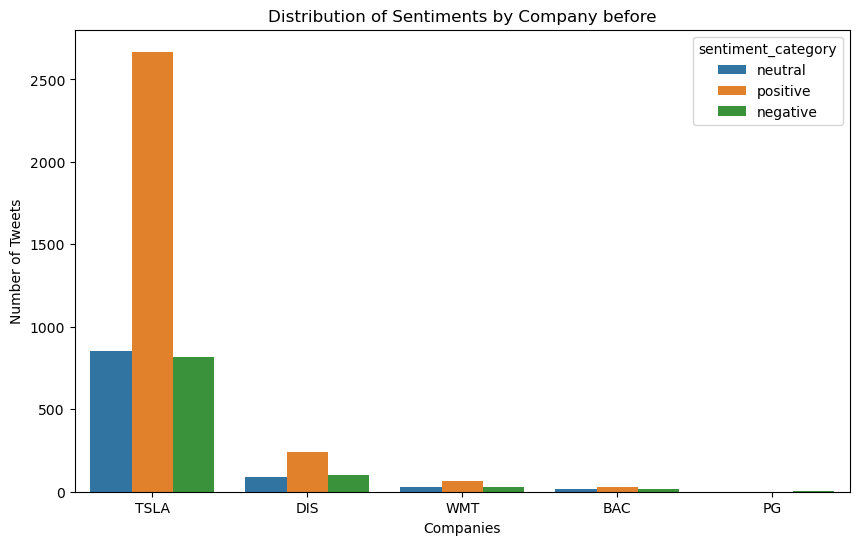

In [29]:
show_distribution_tweets(df_sentiment_with_category.toPandas(), "Distribution of Sentiments by Company before")

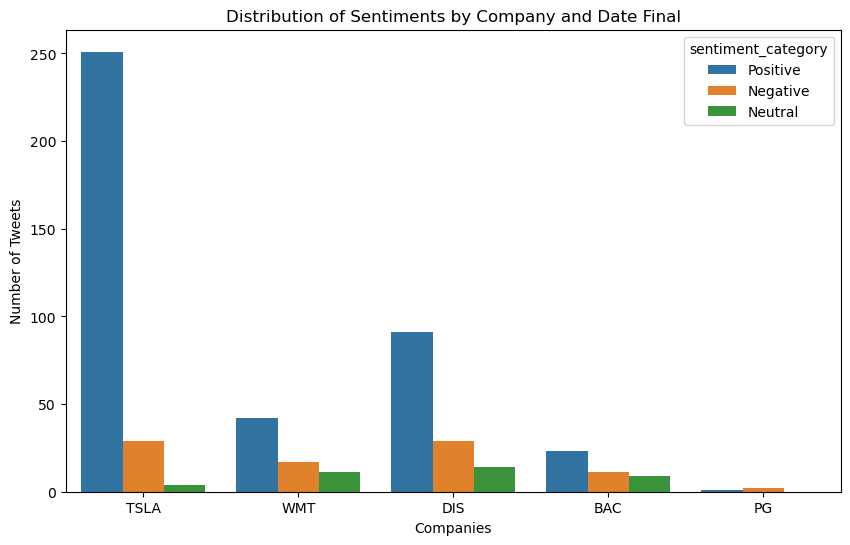

In [30]:
show_distribution_tweets(df_sentiment_final.toPandas(), "Distribution of Sentiments by Company and Date Final")

We have finished cleaning and analyzing the tweets.

# Processing Prices

Next, it is time to process the closing price of the shares. For that we will obtain from the database the records of the prices table.

In [31]:
prices = spark.sql("Select * from prices;")
prices.show(5)
print(prices.count())

+----------+------------------+------------------+------------------+------------------+------------------+---------+-------+
|      Date|              Open|              High|               Low|             Close|         Adj Close|   Volume|company|
+----------+------------------+------------------+------------------+------------------+------------------+---------+-------+
|2019-12-31|              27.0|28.086000442504883| 26.80533218383789|  27.8886661529541|  27.8886661529541|154285500|   TSLA|
|2020-01-02|28.299999237060547|28.713333129882812| 28.11400032043457| 28.68400001525879| 28.68400001525879|142981500|   TSLA|
|2020-01-03|29.366666793823242|30.266666412353516|29.128000259399414|29.534000396728516|29.534000396728516|266677500|   TSLA|
|2020-01-06|29.364667892456055|30.104000091552734|29.333332061767578|  30.1026668548584|  30.1026668548584|151995000|   TSLA|
|2020-01-07|30.760000228881836|31.441999435424805|30.224000930786133|31.270666122436523|31.270666122436523|268231500| 

We eliminate the columns that are of interest to us in order to perform a better analysis.

# Drop columns 
prices = prices[['Date', 'Close', 'Volume', 'company']]  # Keep only the columns you need
prices.show(5)
print(prices.count())

## Join Data

Before performing the join we must make sure that the columns that have the same data are in the same format.

In [32]:
tweets_df = df_sentiment_final.withColumn("date", to_date(df_sentiment_final["date"], "dd/MM/yyyy"))

prices_df = prices.withColumn("date", to_date(prices["Date"], "yyyy-MM-dd"))


Below we show the data of both tables to see which columns we will use to make the join.

In [33]:
tweets_df.show(3)
print(tweets_df.count())

prices_df.show(3)
print(prices_df.count())

+----------+------+------------------+------------------+
|      date|ticker|         sentiment|sentiment_category|
+----------+------+------------------+------------------+
|2020-01-24|  TSLA|0.2638999968767166|          Positive|
|2020-02-03|  TSLA|0.4597533330321312|          Positive|
|2020-03-31|   WMT|             0.875|          Positive|
+----------+------+------------------+------------------+
only showing top 3 rows

534
+----------+------------------+------------------+------------------+------------------+------------------+---------+-------+
|      date|              Open|              High|               Low|             Close|         Adj Close|   Volume|company|
+----------+------------------+------------------+------------------+------------------+------------------+---------+-------+
|2019-12-31|              27.0|28.086000442504883| 26.80533218383789|  27.8886661529541|  27.8886661529541|154285500|   TSLA|
|2020-01-02|28.299999237060547|28.713333129882812| 28.1140003

Here we will make a union to the right because we do not want to lose the price data at the close of the shares. This will result in a table with the same amount of records as the prices table. 

In [34]:
# Merge the data by date and ticker
merged_df = tweets_df.join(prices_df, (tweets_df["date"] == prices_df["date"]) & (tweets_df["ticker"] == prices_df["company"]), "right")
merged_df.show(5)
print(merged_df.count())

+----------+------+--------------------+------------------+----------+------------------+------------------+------------------+------------------+------------------+---------+-------+
|      date|ticker|           sentiment|sentiment_category|      date|              Open|              High|               Low|             Close|         Adj Close|   Volume|company|
+----------+------+--------------------+------------------+----------+------------------+------------------+------------------+------------------+------------------+---------+-------+
|      null|  null|                null|              null|2019-12-31|              27.0|28.086000442504883| 26.80533218383789|  27.8886661529541|  27.8886661529541|154285500|   TSLA|
|2020-01-02|  TSLA|-0.32910001277923584|          Negative|2020-01-02|28.299999237060547|28.713333129882812| 28.11400032043457| 28.68400001525879| 28.68400001525879|142981500|   TSLA|
|2020-01-03|  TSLA| 0.36481667558352154|          Positive|2020-01-03|29.3666667

We eliminate the columns that were repeated.

In [35]:
# Remove duplicate columns, keeping only the necessary ones
merged_df = merged_df.drop(tweets_df["date"])
merged_df.show(5)
print(merged_df.count())


+------+--------------------+------------------+----------+------------------+------------------+------------------+------------------+------------------+---------+-------+
|ticker|           sentiment|sentiment_category|      date|              Open|              High|               Low|             Close|         Adj Close|   Volume|company|
+------+--------------------+------------------+----------+------------------+------------------+------------------+------------------+------------------+---------+-------+
|  null|                null|              null|2019-12-31|              27.0|28.086000442504883| 26.80533218383789|  27.8886661529541|  27.8886661529541|154285500|   TSLA|
|  TSLA|-0.32910001277923584|          Negative|2020-01-02|28.299999237060547|28.713333129882812| 28.11400032043457| 28.68400001525879| 28.68400001525879|142981500|   TSLA|
|  TSLA| 0.36481667558352154|          Positive|2020-01-03|29.366666793823242|30.266666412353516|29.128000259399414|29.534000396728516|

In [36]:
# Remove duplicate columns, keeping only the necessary ones
merged_df = merged_df.drop(tweets_df["ticker"])
merged_df.show(5)
print(merged_df.count())


+--------------------+------------------+----------+------------------+------------------+------------------+------------------+------------------+---------+-------+
|           sentiment|sentiment_category|      date|              Open|              High|               Low|             Close|         Adj Close|   Volume|company|
+--------------------+------------------+----------+------------------+------------------+------------------+------------------+------------------+---------+-------+
|                null|              null|2019-12-31|              27.0|28.086000442504883| 26.80533218383789|  27.8886661529541|  27.8886661529541|154285500|   TSLA|
|-0.32910001277923584|          Negative|2020-01-02|28.299999237060547|28.713333129882812| 28.11400032043457| 28.68400001525879| 28.68400001525879|142981500|   TSLA|
| 0.36481667558352154|          Positive|2020-01-03|29.366666793823242|30.266666412353516|29.128000259399414|29.534000396728516|29.534000396728516|266677500|   TSLA|
| 0.

## Analysis and Preparation for Prediction

We will now separate the records by company and store them in an array.

Up to this point we already know that there are companies that have almost no tweets so some or many records will have null data in the sentiment.

In order to make a prediction where the tweets are also taken into account we have chosen to use two filling techniques:

- The first is that if the company records have more than 80% null, then we will only fill with the value of neutral for that day's sentiment.
- The second technique only applies if the nulls in the sentiment are 80% less, this is where we will apply a predictive model to fill the sentiment.

In each iteration we will update the data for each company and store it temporarily in a variable for later processing in the closing prediction.

To get a better idea of how the closings are distributed throughout the year, we add a graph that represents those values.


Company: BAC, Percentage of null values in 'sentiment': 83.46%
More than 80% of null values in 'sentiment' for BAC. Filling with 0.
+----------+---------+------------------+------------------+
|      date|sentiment|sentiment_category|             Close|
+----------+---------+------------------+------------------+
|2019-12-31|      0.0|           Neutral|35.220001220703125|
|2020-01-02|      0.0|           Neutral| 35.63999938964844|
|2020-01-03|      0.0|           Neutral|34.900001525878906|
|2020-01-06|      0.0|           Neutral|34.849998474121094|
|2020-01-07|      0.0|           Neutral|34.619998931884766|
+----------+---------+------------------+------------------+
only showing top 5 rows

Number of null values in 'sentiment' after filling for BAC: 0


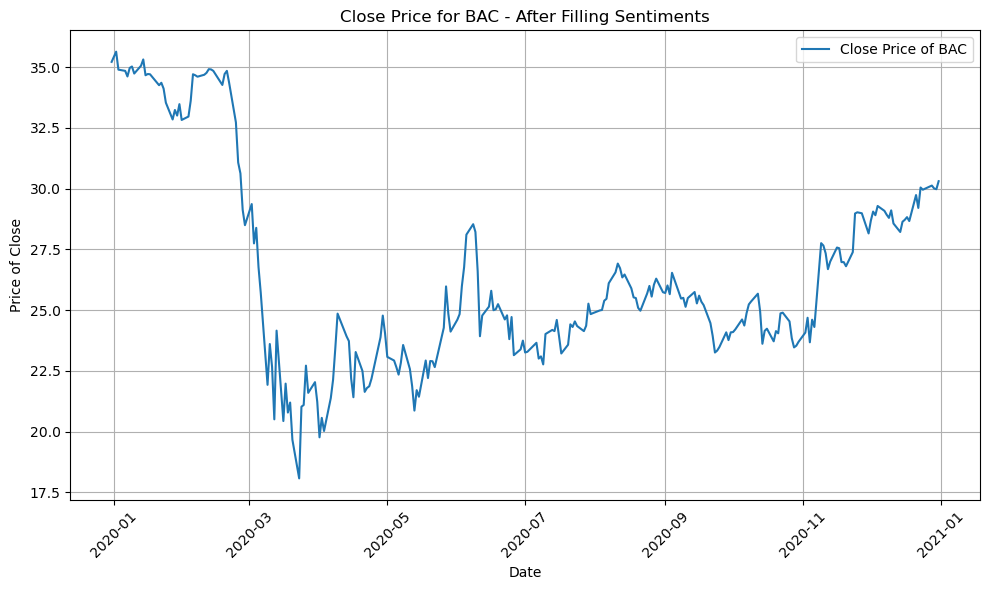

Company: DIS, Percentage of null values in 'sentiment': 50.79%
Filling null values with a predictive model for DIS.
+----------+-------------------+------------------+------------------+
|      date|          sentiment|sentiment_category|             Close|
+----------+-------------------+------------------+------------------+
|2019-12-31|0.23000669256703915|          Positive| 144.6300048828125|
|2020-01-02|                0.0|           Neutral| 148.1999969482422|
|2020-01-03| 0.2321752536322331|          Positive|             146.5|
|2020-01-06| 0.2311895344053115|          Positive|145.64999389648438|
|2020-01-07| -0.599399983882904|          Negative| 145.6999969482422|
+----------+-------------------+------------------+------------------+
only showing top 5 rows

Number of null values in 'sentiment' after filling for DIS: 0


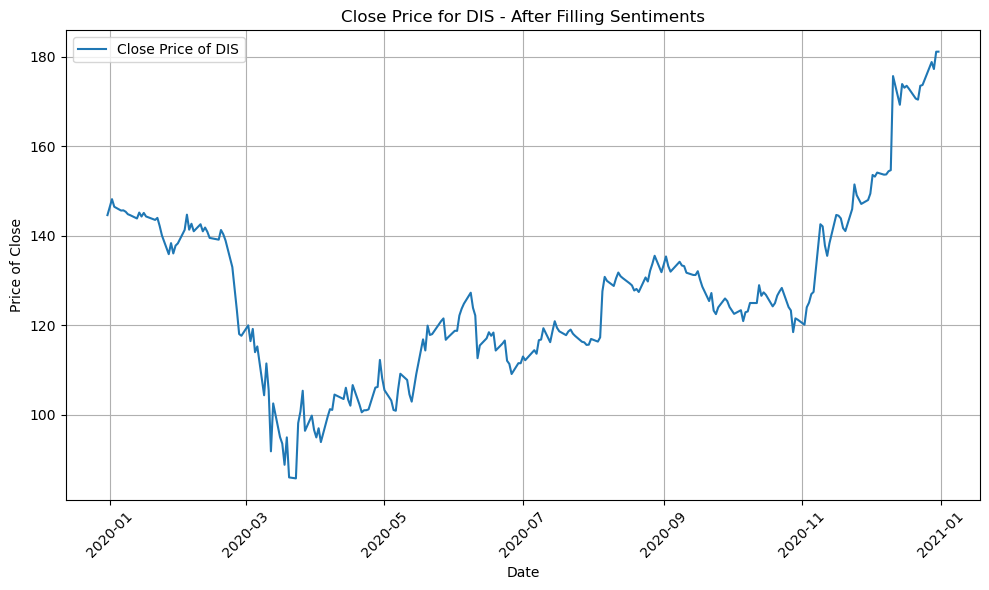

Company: PG, Percentage of null values in 'sentiment': 98.82%
More than 80% of null values in 'sentiment' for PG. Filling with 0.
+----------+---------+------------------+------------------+
|      date|sentiment|sentiment_category|             Close|
+----------+---------+------------------+------------------+
|2019-12-31|      0.0|           Neutral| 124.9000015258789|
|2020-01-02|      0.0|           Neutral|123.41000366210938|
|2020-01-03|      0.0|           Neutral|122.58000183105469|
|2020-01-06|      0.0|           Neutral|            122.75|
|2020-01-07|      0.0|           Neutral|121.98999786376953|
+----------+---------+------------------+------------------+
only showing top 5 rows

Number of null values in 'sentiment' after filling for PG: 0


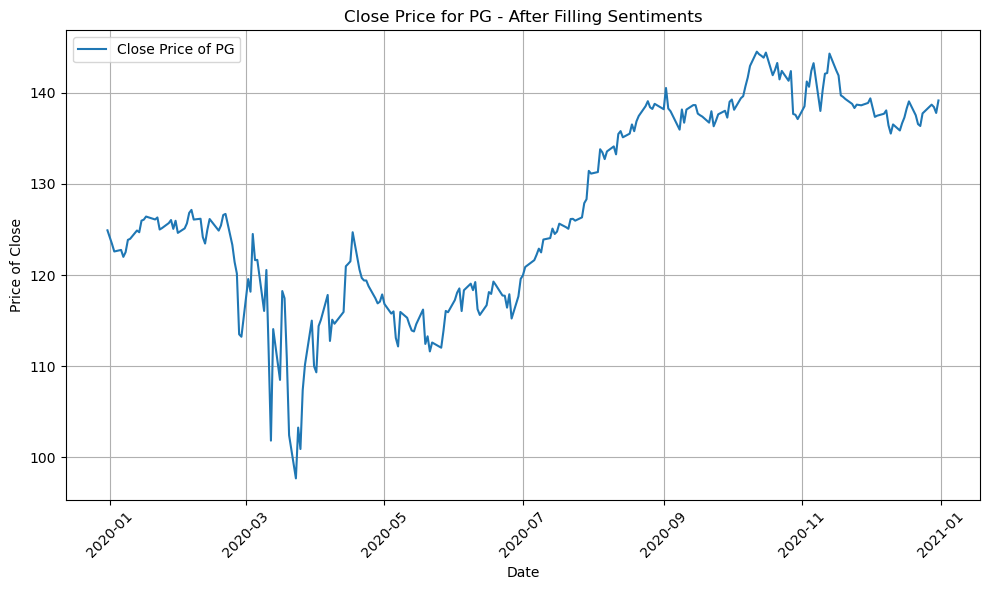

Company: TSLA, Percentage of null values in 'sentiment': 3.94%
Filling null values with a predictive model for TSLA.
+----------+--------------------+------------------+------------------+
|      date|           sentiment|sentiment_category|             Close|
+----------+--------------------+------------------+------------------+
|2019-12-31| 0.24085062420920958|          Positive|  27.8886661529541|
|2020-01-02|-0.32910001277923584|          Negative| 28.68400001525879|
|2020-01-03| 0.36481667558352154|          Positive|29.534000396728516|
|2020-01-06| 0.20195000618696213|          Positive|  30.1026668548584|
|2020-01-07|  0.1834687520749867|          Positive|31.270666122436523|
+----------+--------------------+------------------+------------------+
only showing top 5 rows

Number of null values in 'sentiment' after filling for TSLA: 0


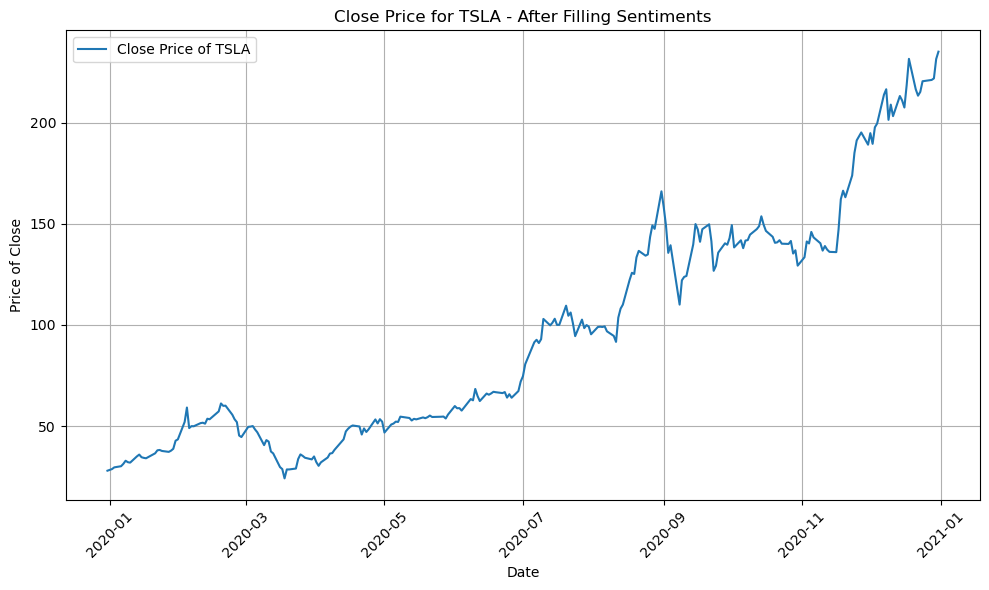

Company: WMT, Percentage of null values in 'sentiment': 73.23%
Filling null values with a predictive model for WMT.
+----------+--------------------+------------------+------------------+
|      date|           sentiment|sentiment_category|             Close|
+----------+--------------------+------------------+------------------+
|2019-12-31| 0.22468189329969177|          Positive|118.83999633789062|
|2020-01-02| 0.22457742312968873|          Positive|118.94000244140625|
|2020-01-03| 0.22567429615508078|          Positive|117.88999938964844|
|2020-01-06|  0.2259250070291871|          Positive| 117.6500015258789|
|2020-01-07|-0.49390000104904175|          Negative|116.55999755859375|
+----------+--------------------+------------------+------------------+
only showing top 5 rows

Number of null values in 'sentiment' after filling for WMT: 0


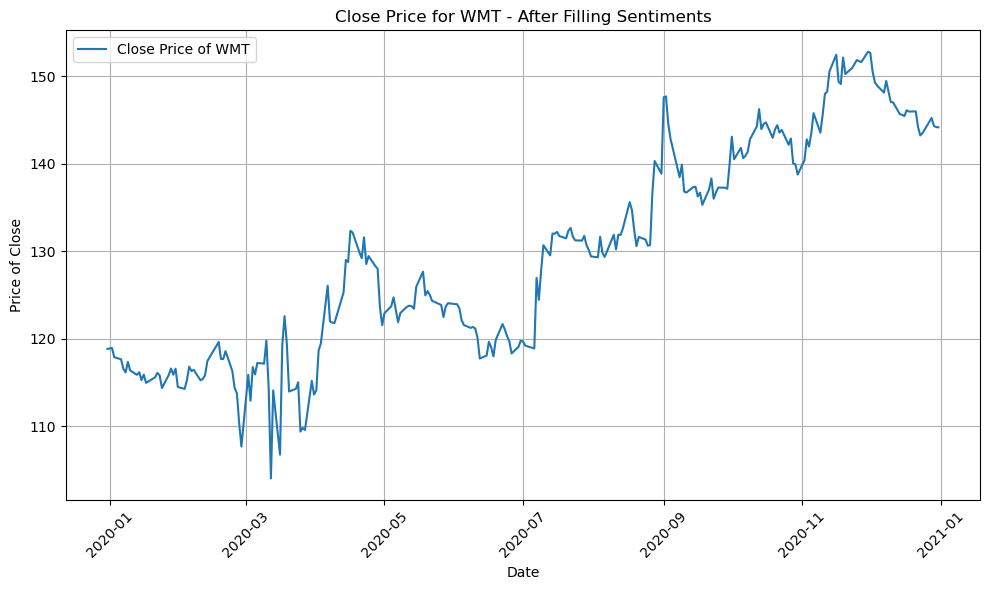

In [42]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pyspark.sql import functions as F
from pyspark.sql.functions import col
import numpy as np
from pyspark.sql import Row

# Función para filtrar los datos por compañía
def filter_data_by_company(merged_df, companies):
    company_data = {}
    for company in companies:
        company_data[company] = merged_df.filter(merged_df['company'] == company)
    return company_data

# Función para calcular el porcentaje de valores nulos y decidir el llenado de los nulos
def handle_null_values(company_data, company):
    # Contar cuántos valores nulos hay en la columna 'sentiment'
    null_sentiment_count = company_data[company].filter(F.col('sentiment').isNull()).count()
    total_count = company_data[company].count()
    
    # Calcular el porcentaje de valores nulos en la columna 'sentiment'
    null_percentage = null_sentiment_count / total_count
    print(f"Company: {company}, Percentage of null values in 'sentiment': {null_percentage * 100:.2f}%")
    
    if null_percentage > 0.8:
        print(f"More than 80% of null values in 'sentiment' for {company}. Filling with 0.")
        company_data[company] = company_data[company].fillna({'sentiment': 0})
    else:
        print(f"Filling null values with a predictive model for {company}.")
        company_data[company] = fill_null_with_model(company_data[company], company)
    
    return company_data

# Función para llenar los valores nulos usando un modelo predictivo con sklearn
def fill_null_with_model(company_df, company):
    # Filtrar solo las filas con valores no nulos en 'sentiment'
    train_data = company_df.filter(F.col('sentiment').isNotNull())

    # Convertir las columnas relevantes a arrays de numpy
    train_data_arr = np.array(train_data.select('Close', 'sentiment').rdd.map(lambda row: (row['Close'], row['sentiment'])).collect())
    X_train = train_data_arr[:, 0].reshape(-1, 1)  # Variables independientes (Close)
    y_train = train_data_arr[:, 1]  # Variable dependiente (sentiment)
    
    # Entrenar el modelo de regresión lineal de sklearn
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Filtrar las filas con valores nulos en 'sentiment'
    test_data = company_df.filter(F.col('sentiment').isNull())
    
    # Convertir las columnas relevantes a arrays de numpy para la predicción
    test_data_arr = np.array(test_data.select('Close').rdd.map(lambda row: row['Close']).collect()).reshape(-1, 1)
    
    # Realizar las predicciones para los valores nulos de 'sentiment'
    predictions = model.predict(test_data_arr)
    
    # Convertir las predicciones a un DataFrame de PySpark, asegurándose de que los valores sean del tipo correcto
    predictions_df = [Row(date=row['date'], prediction=float(pred)) for row, pred in zip(test_data.select('date').collect(), predictions)]
    predictions_spark_df = spark.createDataFrame(predictions_df)
    
    # Unir las predicciones con el DataFrame original
    company_df = company_df.join(predictions_spark_df, on='date', how='left')
    
    # Actualizar los valores nulos con las predicciones en 'sentiment'
    company_df = company_df.withColumn(
        'sentiment', 
        F.coalesce(F.col('sentiment'), F.col('prediction'))
    )
    
    # Eliminar la columna 'prediction' ya que ya no es necesaria
    company_df = company_df.drop('prediction')
    
    return company_df

# Función para crear la columna 'sentiment_category' basada en los valores de 'sentiment'
def create_sentiment_category(company_data, company):
    company_data[company] = company_data[company].withColumn(
        'sentiment_category',
        F.when(F.col('sentiment') > 0, 'Positive')
        .when(F.col('sentiment') < 0, 'Negative')
        .otherwise('Neutral')
    ).orderBy('date')
    
    return company_data

# Función para graficar los resultados
def plot_results(company_data, company):
    # Recoger los datos en una lista de tuplas (date, Close, sentiment) para graficar
    company_data_list = company_data[company].select('date', 'Close', 'sentiment').orderBy('date').collect()

    # Extraer fechas, precios de cierre y valores de sentimiento
    dates = [row['date'] for row in company_data_list]
    close_prices = [row['Close'] for row in company_data_list]
    sentiments = [row['sentiment'] for row in company_data_list]
    
    # Graficar 'Close' contra 'date'
    plt.figure(figsize=(10, 6))
    plt.plot(dates, close_prices, label=f'Close Price of {company}')
    
    # Agregar título y etiquetas
    plt.title(f'Close Price for {company} - After Filling Sentiments')
    plt.xlabel('Date')
    plt.ylabel('Price of Close')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)  # Rotar las fechas para mejor lectura
    plt.tight_layout()  # Ajustar márgenes
    plt.show()

# Función principal que organiza todo el proceso
def process_companies(merged_df, companies):
    company_data = filter_data_by_company(merged_df, companies)
    filled_data = {}  # Diccionario para almacenar los DataFrames rellenados

    for company in companies:
        # Manejar los valores nulos en 'sentiment'
        company_data = handle_null_values(company_data, company)
        
        # Crear la categoría de sentimiento
        company_data = create_sentiment_category(company_data, company)

        # Seleccionar solo las columnas relevantes
        company_data[company] = company_data[company].select('date', 'sentiment', 'sentiment_category', 'Close')
        
        
        # Guardar el DataFrame rellenado en el diccionario filled_data
        filled_data[company] = company_data[company]
        
        # Mostrar los primeros registros después de llenar los valores nulos
        company_data[company].show(5)

        # Contar nuevamente los valores nulos después de la imputación
        null_sentiment_count_after = company_data[company].filter(F.col('sentiment').isNull()).count()
        print(f"Number of null values in 'sentiment' after filling for {company}: {null_sentiment_count_after}")
        
        # Graficar los resultados
        plot_results(company_data, company)

    return filled_data  # Devolver el diccionario con los DataFrames rellenados

# Lista de compañías seleccionadas
companies = ['BAC', 'DIS', 'PG', 'TSLA', 'WMT']

# Llamar a la función principal para procesar las compañías y guardar los DataFrames rellenados
filled_company_data = process_companies(merged_df, companies)


### ARIMA Model

In [43]:
companies = ['BAC', 'DIS', 'PG', 'TSLA', 'WMT']

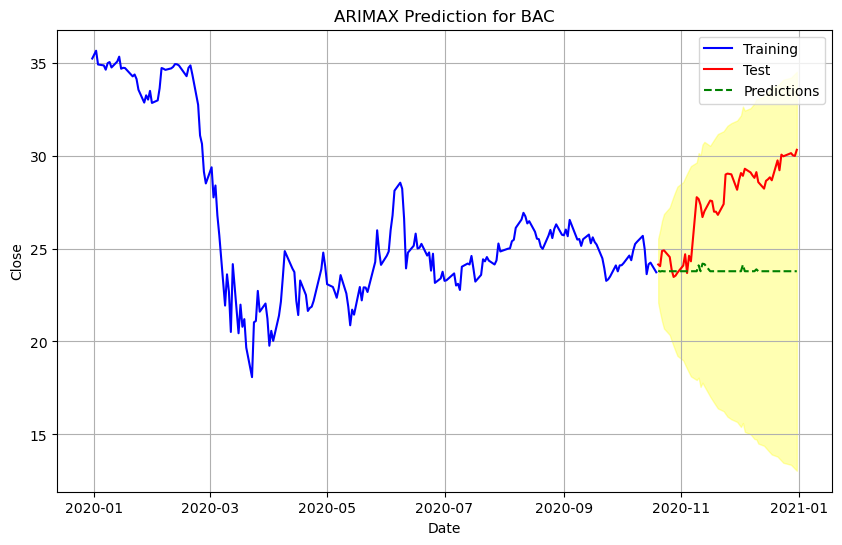

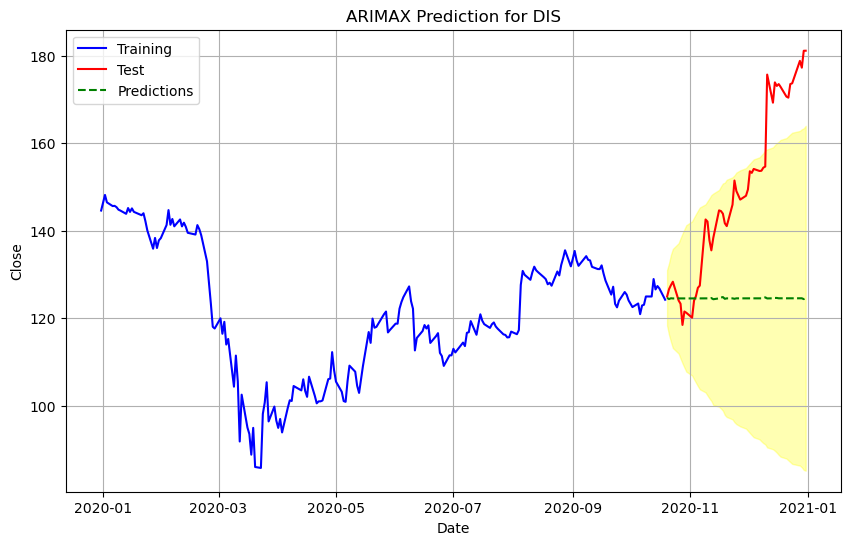

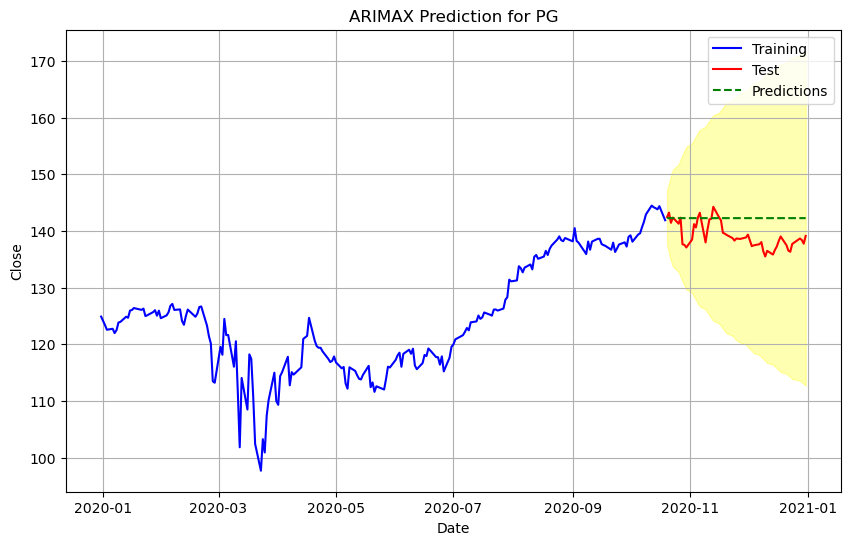

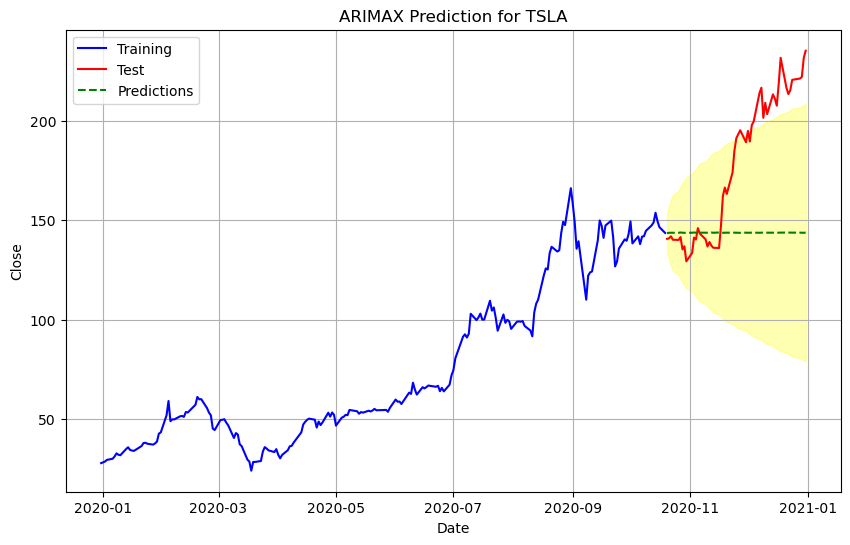

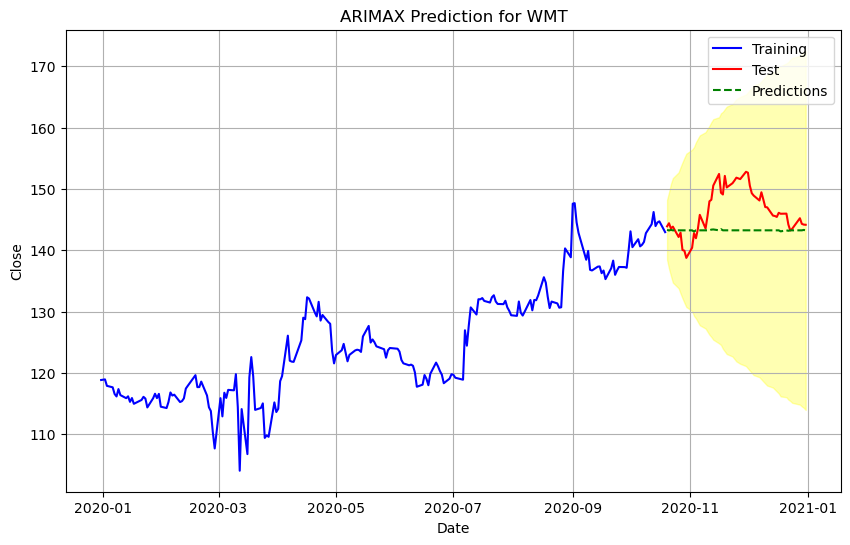

In [44]:
# Function to apply ARIMAX and plot results
def arimax_predict(filled_company_data, companies, alpha=0.05):
    for company in companies:
        # Filter the data for each company (PySpark DataFrame)
        df = filled_company_data[company]
        
        # Ensure the data is ordered by date using orderBy in PySpark
        df = df.orderBy('date')  # This orders by the 'date' column
        
        # Convert the PySpark DataFrame to pandas for ARIMAX
        df = df.toPandas()  # Convert to pandas DataFrame
        
        # Split the data into 80% training and 20% testing
        train, test = train_test_split(df, test_size=0.2, shuffle=False)
        
        # Define the input variables
        X_train = train[['sentiment']]  # Exogenous variables
        y_train = train['Close']  # Dependent variable
        
        # ARIMAX - Fit the ARIMA model with exogenous variable
        model = ARIMA(y_train, exog=X_train, order=(1, 1, 1))  # p, d, q
        model_fit = model.fit()
        
        # Generate predictions
        X_test = test[['sentiment']]
        pred = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, exog=X_test)
        
        # Calculate confidence intervals (use 1.96 for the 95% confidence interval)
        conf_int = model_fit.get_forecast(steps=len(test), exog=X_test).conf_int(alpha=alpha)
        
        # Plot the results
        plt.figure(figsize=(10, 6))
        plt.plot(train['date'], y_train, label='Training', color='blue')
        plt.plot(test['date'], test['Close'], label='Test', color='red')
        plt.plot(test['date'], pred, label='Predictions', color='green', linestyle='dashed')
        plt.fill_between(test['date'], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='yellow', alpha=0.3)
        
        # Configure the plot
        plt.title(f"ARIMAX Prediction for {company}")
        plt.xlabel('Date')
        plt.ylabel('Close')
        plt.legend()
        plt.grid(True)
        plt.show()

# Call the function to make predictions and plot
arimax_predict(filled_company_data, companies)


# Optimization

GridSearch will be used to find the best hyperparameters. 

/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/anaconda3/lib/python3.12/

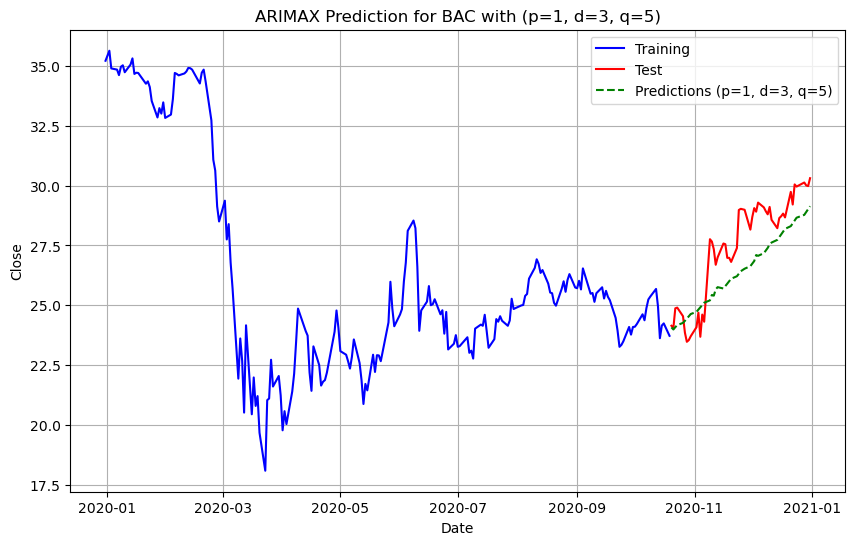

/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/anaconda3/lib/python3.12/

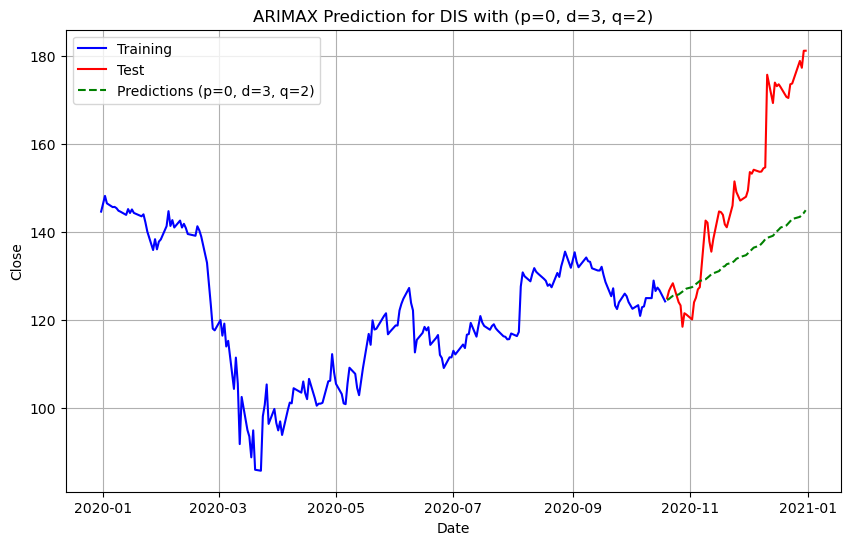

/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/anaconda3/lib/python3.12/

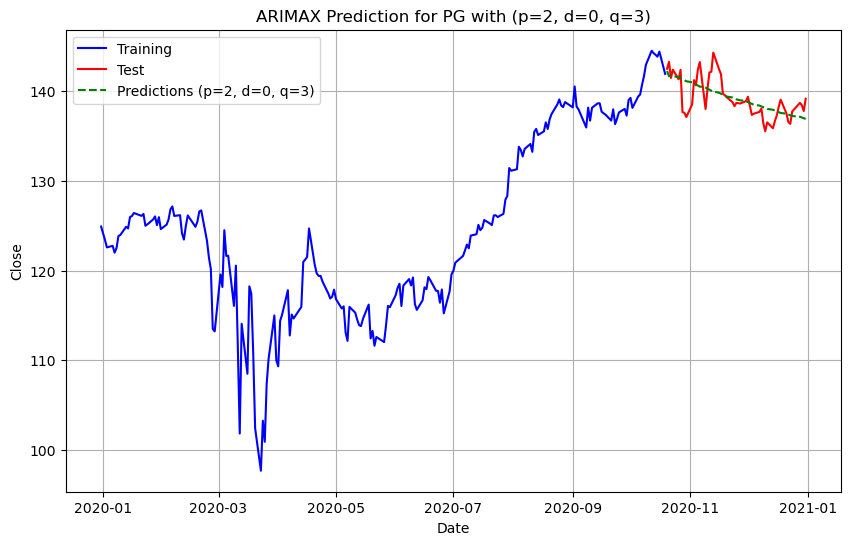

/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/t

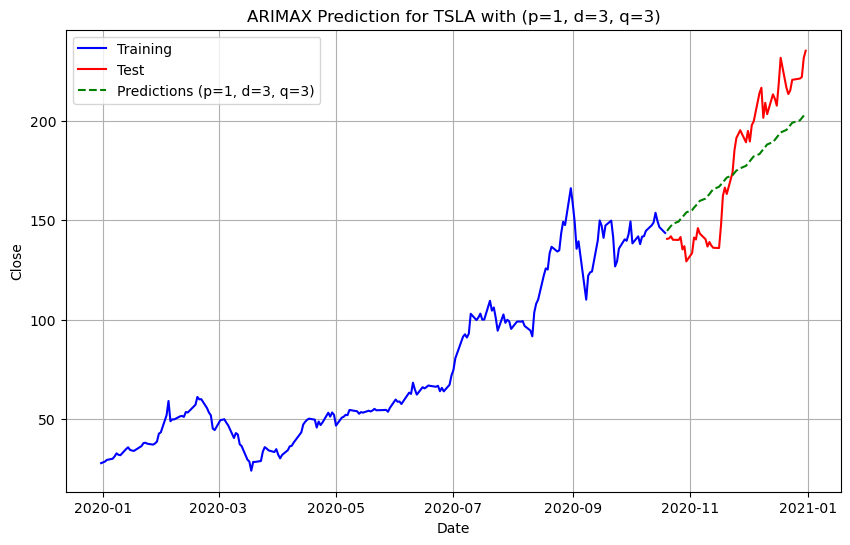

/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/anaconda3/lib/python3.12/

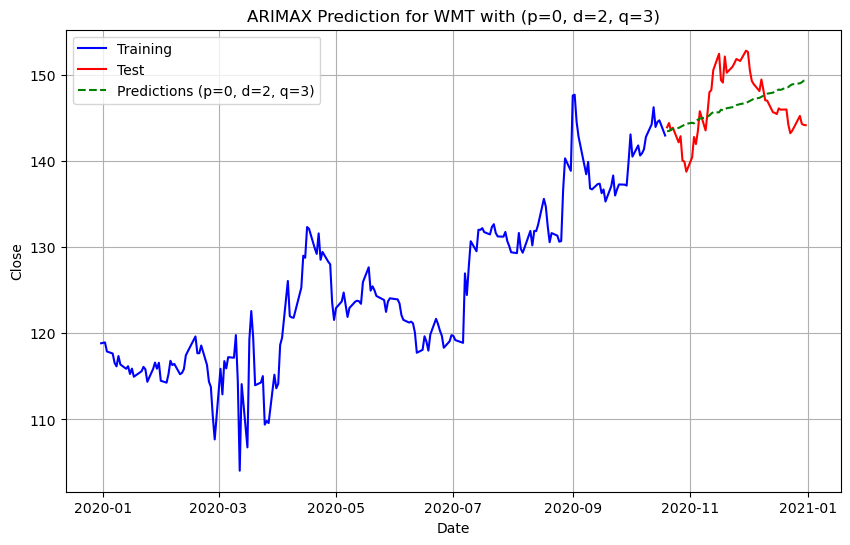

Best parameters and RMSE for each company:
BAC: (p=1, d=3, q=5) -> RMSE: 1.4054670555167534
DIS: (p=0, d=3, q=2) -> RMSE: 19.772953139174103
PG: (p=2, d=0, q=3) -> RMSE: 1.687645355761494
TSLA: (p=1, d=3, q=3) -> RMSE: 19.7601628695641
WMT: (p=0, d=2, q=3) -> RMSE: 3.613269670284876


In [45]:
from itertools import product
# Function to apply ARIMAX and plot results with the best hyperparameters
def arimax_predict_with_gridsearch(company_data, companies, param_grid, alpha=0.05):
    # Dictionary to store the best parameters and models for each company
    best_models = {}  # To store the fitted ARIMAX model
    best_params = {}  # To store the best parameters (p, d, q)
    best_score = {}  # To store the lowest RMSE
    
    for company in companies:
        # Filter the data for each company (PySpark DataFrame)
        df = company_data[company]
        
        # Ensure that the data is ordered by date using orderBy in PySpark
        df = df.orderBy('date')  # This sorts by the 'date' column
        
        # Convert the PySpark DataFrame to pandas to work with ARIMAX
        df = df.toPandas()  # Convert to pandas DataFrame
        
        # Split the data into 80% training and 20% testing
        train, test = train_test_split(df, test_size=0.2, shuffle=False)
        
        # Define the input variables
        X_train = train[['sentiment']]  # Exogenous variables
        y_train = train['Close']  # Dependent variable
        
        best_score_for_company = float('inf')
        best_param_for_company = None
        best_model_for_company = None
        
        # Grid search to optimize the hyperparameters
        for p, d, q in product(param_grid['p'], param_grid['d'], param_grid['q']):
            try:
                # ARIMAX - Fit the ARIMA model with the selected parameters
                model = ARIMA(y_train, exog=X_train, order=(p, d, q))
                model_fit = model.fit()
                
                # Make predictions
                X_test = test[['sentiment']]
                pred = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, exog=X_test)
                
                # Evaluate the model with RMSE
                mse = mean_squared_error(test['Close'], pred)
                rmse = np.sqrt(mse)

                # If the RMSE is the lowest, store the parameters and model
                if rmse < best_score_for_company:
                    best_score_for_company = rmse
                    best_param_for_company = (p, d, q)
                    best_model_for_company = model_fit

            except Exception as e:
                print(f"Error with the model (p={p}, d={d}, q={q}): {e}")
        
        # Save the best parameters and the fitted model for each company
        best_params[company] = best_param_for_company
        best_score[company] = best_score_for_company
        best_models[company] = best_model_for_company

        # Plot only the results with the best hyperparameters for each company
        p, d, q = best_param_for_company
        model = ARIMA(y_train, exog=X_train, order=(p, d, q))
        model_fit = model.fit()

        # Make predictions with the best parameters
        X_test = test[['sentiment']]
        pred = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, exog=X_test)
        
        # Plot the results
        plt.figure(figsize=(10, 6))
        plt.plot(train['date'], y_train, label='Training', color='blue')
        plt.plot(test['date'], test['Close'], label='Test', color='red')
        plt.plot(test['date'], pred, label=f'Predictions (p={p}, d={d}, q={q})', color='green', linestyle='dashed')
        plt.title(f"ARIMAX Prediction for {company} with (p={p}, d={d}, q={q})")
        plt.xlabel('Date')
        plt.ylabel('Close')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Print the best parameters found for each company
    print("Best parameters and RMSE for each company:")
    for company in companies:
        print(f"{company}: (p={best_params[company][0]}, d={best_params[company][1]}, q={best_params[company][2]}) -> RMSE: {best_score[company]}")

    return best_models, best_params  # Return the models and parameters to be used later

# Function to make future predictions with the best models
def make_future_predictions(best_models, best_params, company_data, company, days_to_predict):
    # Get the fitted model and parameters for the selected company
    model_fit = best_models.get(company)
    if not model_fit:
        print(f"No model found for the company {company}")
        return None
    
    # Get the optimal parameters
    p, d, q = best_params[company]

    # Retrieve the data for the selected company
    df = company_data[company].toPandas()  # Convert to pandas DataFrame
    X = df[['sentiment']]  # Exogenous variables
    y = df['Close']  # Dependent variable

    # Make future predictions
    X_future = X[-days_to_predict:]  # Use the last rows to predict future values

    # Make predictions for 1, 3, and 7 days
    predictions = model_fit.predict(start=len(df), end=len(df) + days_to_predict - 1, exog=X_future)
    
    print(f"Predictions for {company} in {days_to_predict} days: {predictions}")
    return predictions

# Define the search space for the hyperparameters (p, d, q)
param_grid = {
    'p': [0, 1, 2, 3, 4, 5],
    'd': [0, 1, 2, 3],
    'q': [0, 1, 2, 3, 4, 5]
}

# Call the function to make predictions and plot with GridSearch
best_models, best_params = arimax_predict_with_gridsearch(filled_company_data, companies, param_grid)


In [ ]:
# Example of how to make future predictions
company = 'BAC'  # Assuming you have a company named 'BAC'
predictions_1_day = make_future_predictions(best_models, best_params, filled_company_data, company, days_to_predict=1)
predictions_3_days = make_future_predictions(best_models, best_params, filled_company_data, company, days_to_predict=3)
predictions_7_days = make_future_predictions(best_models, best_params, filled_company_data, company, days_to_predict=7)


# Final Values
BAC: (p=1, d=3, q=5) -> RMSE: 1.4054670555167534

DIS: (p=0, d=3, q=2) -> RMSE: 19.772953139174103

PG: (p=2, d=0, q=3) -> RMSE: 1.687645355761494

TSLA: (p=1, d=3, q=3) -> RMSE: 19.7601628695641

WMT: (p=0, d=2, q=3) -> RMSE: 3.613269670284876



In [46]:
filled_company_data['BAC'].show(3)

+----------+---------+------------------+------------------+
|      date|sentiment|sentiment_category|             Close|
+----------+---------+------------------+------------------+
|2019-12-31|      0.0|           Neutral|35.220001220703125|
|2020-01-02|      0.0|           Neutral| 35.63999938964844|
|2020-01-03|      0.0|           Neutral|34.900001525878906|
+----------+---------+------------------+------------------+
only showing top 3 rows



### LSTM Model

Epoch 1/10


W0000 00:00:1733949785.187432   91931 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/hduser/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.1646 - val_loss: 0.0664
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0361 - val_loss: 0.0091
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0423 - val_loss: 0.0096
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0239 - val_loss: 0.0317
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0281 - val_loss: 0.0279
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0226 - val_loss: 0.0123
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0193 - val_loss: 0.0114
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0231 - val_loss: 0.0226
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0217 - val_loss: 0.0183
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0177 - val_loss: 0.0138
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


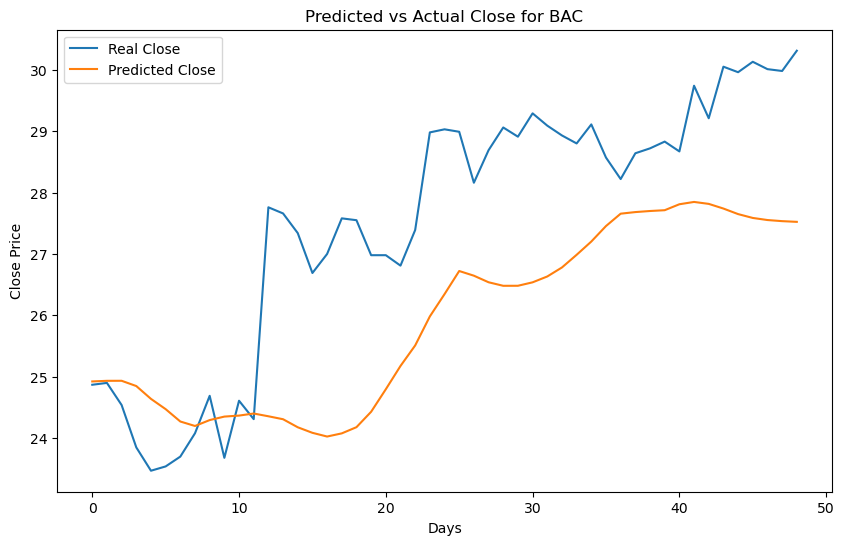

Epoch 1/10


/home/hduser/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.1008 - val_loss: 0.1742
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0229 - val_loss: 0.0430
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0266 - val_loss: 0.0816
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0154 - val_loss: 0.1224
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0144 - val_loss: 0.1005
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0107 - val_loss: 0.0622
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0140 - val_loss: 0.0550
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0091 - val_loss: 0.0632
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0106 - val_loss: 0.0604
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0109 - val_loss: 0.0426
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


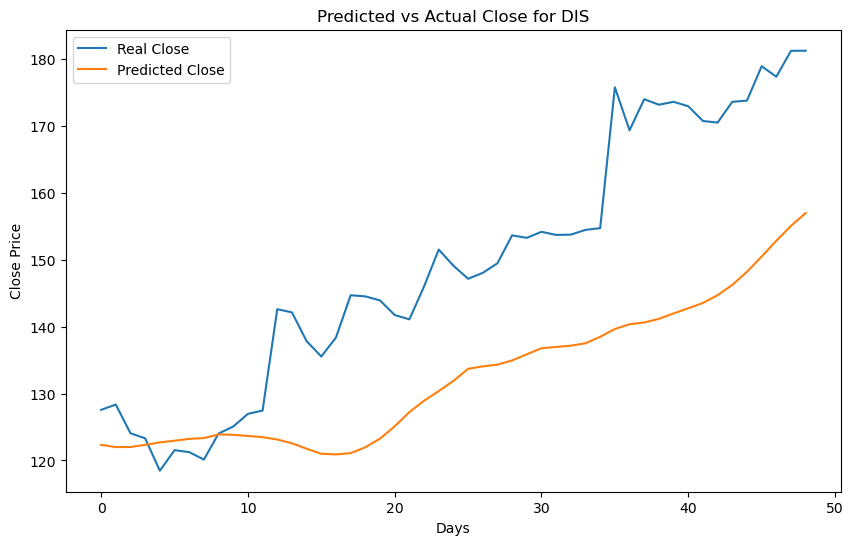

Epoch 1/10


/home/hduser/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.2443 - val_loss: 0.1966
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0689 - val_loss: 0.0031
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0460 - val_loss: 0.0020
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0343 - val_loss: 0.0386
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0294 - val_loss: 0.0324
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0236 - val_loss: 0.0070
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0209 - val_loss: 0.0029
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0195 - val_loss: 0.0057
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0155 - val_loss: 0.0029
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0181 - val_loss: 0.0037
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7

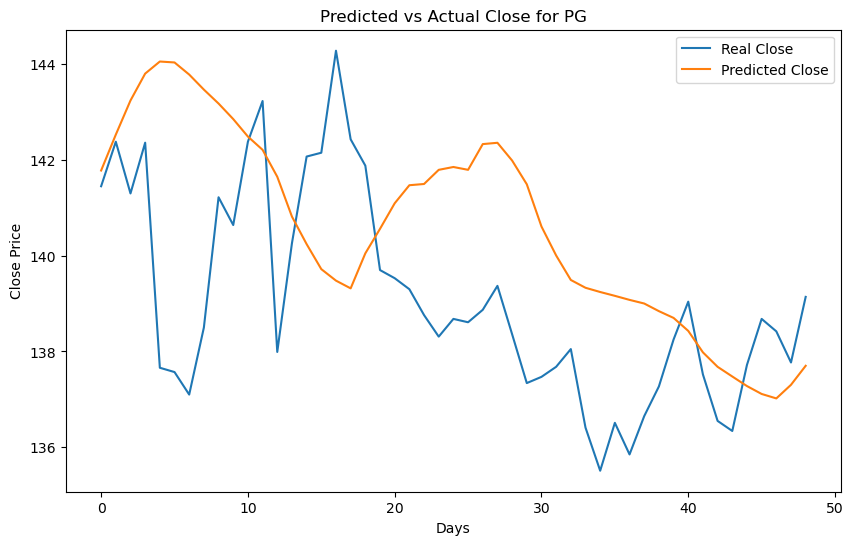

Epoch 1/10


/home/hduser/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0645 - val_loss: 0.1669
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0238 - val_loss: 0.0505
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0177 - val_loss: 0.0699
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0117 - val_loss: 0.0412
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0068 - val_loss: 0.0088
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0059 - val_loss: 0.0093
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0052 - val_loss: 0.0095
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0059 - val_loss: 0.0106
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0051 - val_loss: 0.0124
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0054 - val_loss: 0.0132
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


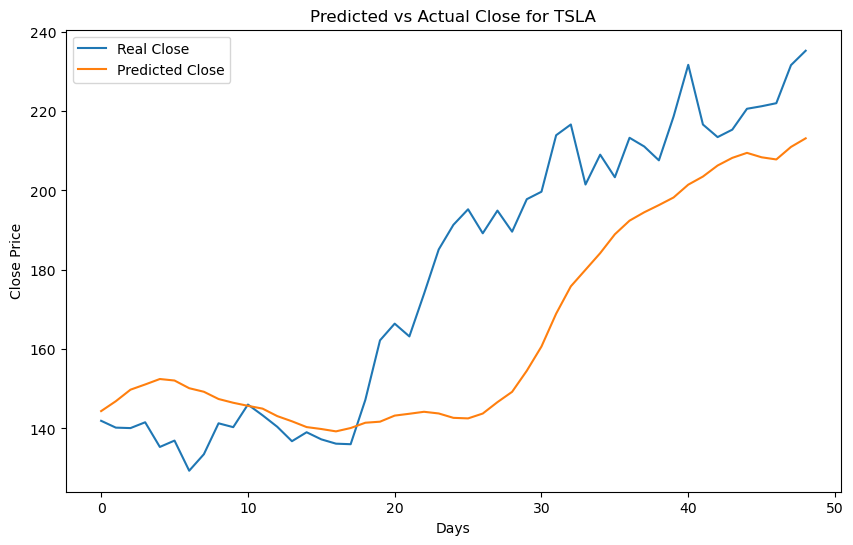

Epoch 1/10


/home/hduser/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.1878 - val_loss: 0.2957
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0443 - val_loss: 0.0278
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0416 - val_loss: 0.0276
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0276 - val_loss: 0.0813
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0231 - val_loss: 0.0653
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0193 - val_loss: 0.0176
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0184 - val_loss: 0.0085
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0163 - val_loss: 0.0102
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0164 - val_loss: 0.0101
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0149 - val_loss: 0.0107
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


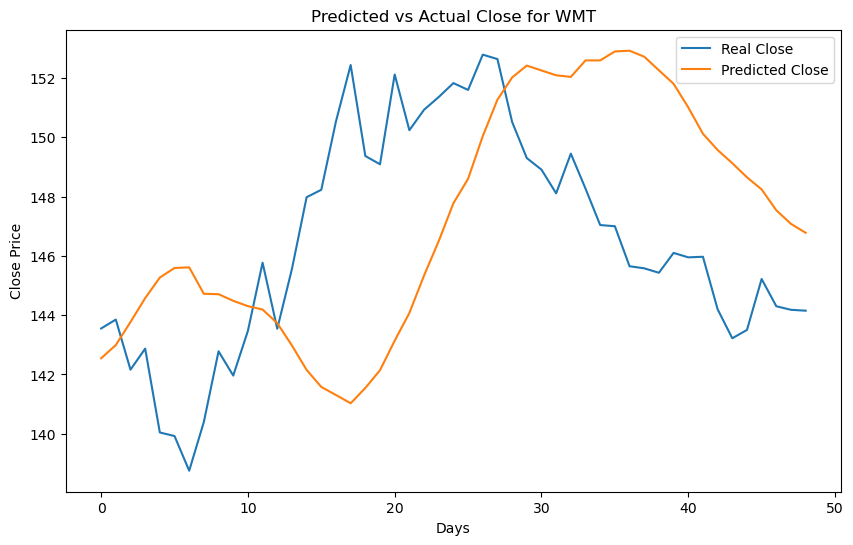

In [47]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from pyspark.sql.functions import col, to_date
import matplotlib.pyplot as plt

# List of companies you want to analyze
companies = ['BAC', 'DIS', 'PG', 'TSLA', 'WMT']

# Loop through each company and apply the LSTM model
for company in companies:
    # Check if your data is a PySpark DataFrame or a Pandas DataFrame
    df_spark = filled_company_data[company]

    # Option 1: If you want to work with Pandas, convert the PySpark DataFrame to Pandas
    df = df_spark.toPandas()

    # Option 2: If you prefer staying with PySpark, use the following to convert 'date' column to date type
    # df_spark = df_spark.withColumn('date', to_date(col('date'), 'yyyy-MM-dd'))

    # 1. Preprocessing
    # Convert the 'date' column to datetime type (in Pandas)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)  # Set the date as the index of the DataFrame

    # Normalize the 'Close' and 'sentiment' columns using MinMaxScaler (values between 0 and 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[['Close', 'sentiment']].values)

    # Create the dataset for LSTM: using a sliding window of 'time_step' to predict the next 'prediction_horizon'
    def create_dataset(data, time_step=7, prediction_horizon=7):
        X = []
        y = []
        for i in range(len(data) - time_step - prediction_horizon + 1):
            X.append(data[i:(i + time_step)])  # Sequence of 'time_step' values
            y.append(data[(i + time_step + prediction_horizon - 1), 0])  # Target value for 'Close' (next price)
        return np.array(X), np.array(y)

    # Prepare the dataset
    time_step = 7  # Number of previous days used for prediction
    prediction_horizon = 7  # Predicting 7 days ahead (can be changed to 1 or 3 for predicting 1 or 3 days)
    X, y = create_dataset(scaled_data, time_step, prediction_horizon)

    # Split the data into training and testing sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # 2. Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))  # LSTM layer
    model.add(Dropout(0.2))  # Dropout layer to avoid overfitting
    model.add(LSTM(units=50, return_sequences=False))  # Another LSTM layer
    model.add(Dropout(0.2))  # Dropout layer
    model.add(Dense(units=1))  # Output layer to predict 'Close' price

    # Compile the model with Adam optimizer and Mean Squared Error loss function
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # 3. Train the model
    # Fit the model to the training data
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

    # 4. Make predictions
    predicted_close = model.predict(X_test)

    # Inverse the scaling transformation to get the actual predicted 'Close' values
    predicted_close = scaler.inverse_transform(np.hstack((predicted_close, np.zeros((predicted_close.shape[0], 1)))))[:, 0]

    # Inverse scaling for actual 'Close' values from the test set
    actual_close = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1)))))[:, 0]

    # 5. Visualize the results
    plt.figure(figsize=(10, 6))
    plt.plot(actual_close, label='Real Close')
    plt.plot(predicted_close, label='Predicted Close')
    plt.legend()
    plt.title(f'Predicted vs Actual Close for {company}')
    plt.xlabel('Days')
    plt.ylabel('Close Price')
    plt.show()


### OPTIMIZATION LSTM

Reloading Tuner from hyperparameter_tuning/BAC_lstm_tuning/tuner0.json


/home/hduser/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/hduser/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best hyperparameters for BAC: {'units_1': 128, 'dropout_1': 0.2, 'units_2': 128, 'dropout_2': 0.30000000000000004, 'learning_rate': 0.0030284296613009858, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0063 
Best model for BAC - Test Loss: 0.005560924299061298
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


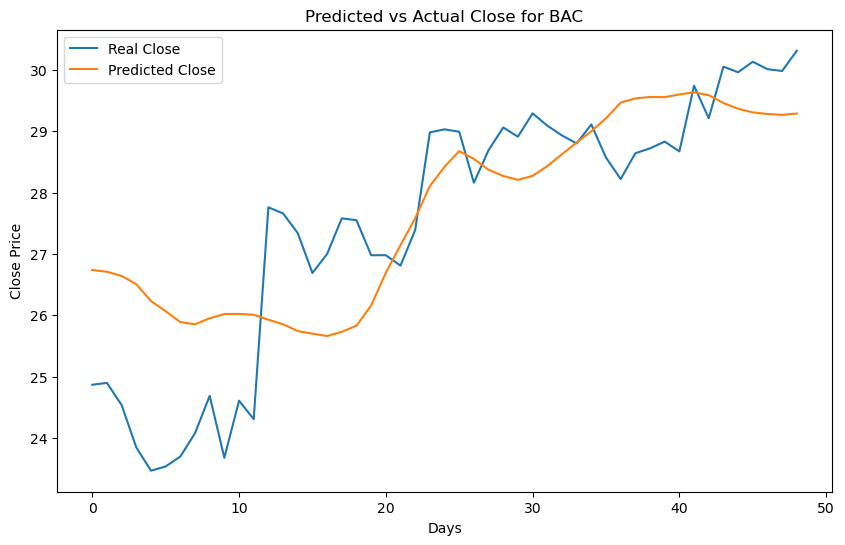

Reloading Tuner from hyperparameter_tuning/DIS_lstm_tuning/tuner0.json


/home/hduser/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/hduser/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best hyperparameters for DIS: {'units_1': 128, 'dropout_1': 0.30000000000000004, 'units_2': 64, 'dropout_2': 0.30000000000000004, 'learning_rate': 0.001293783415272845, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0149 
Best model for DIS - Test Loss: 0.019182834774255753
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


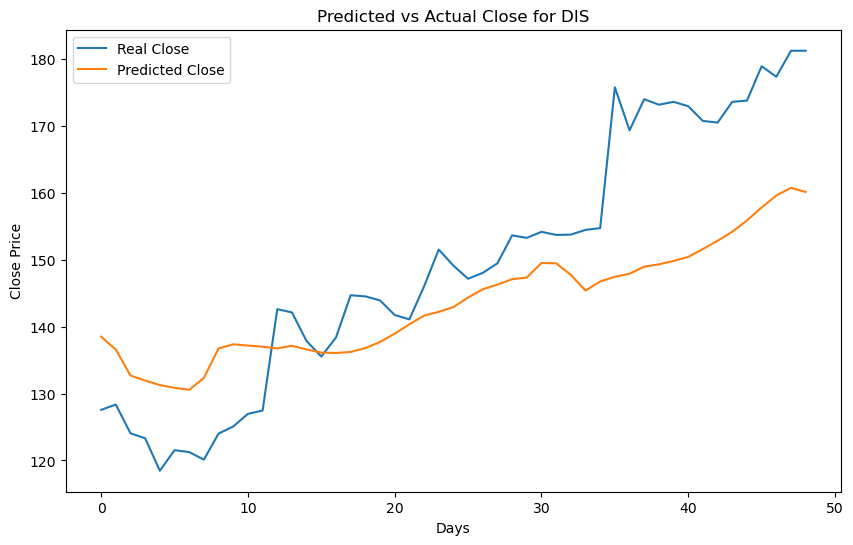

Reloading Tuner from hyperparameter_tuning/PG_lstm_tuning/tuner0.json


/home/hduser/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/hduser/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best hyperparameters for PG: {'units_1': 32, 'dropout_1': 0.30000000000000004, 'units_2': 32, 'dropout_2': 0.30000000000000004, 'learning_rate': 0.003214753279280068, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0052'}


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0023 
Best model for PG - Test Loss: 0.002125347498804331
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


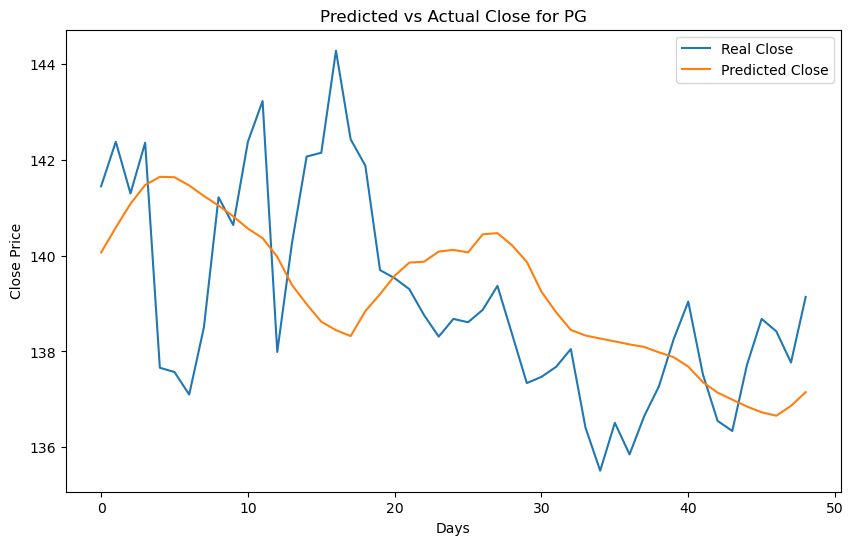

Reloading Tuner from hyperparameter_tuning/TSLA_lstm_tuning/tuner0.json


/home/hduser/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/hduser/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best hyperparameters for TSLA: {'units_1': 32, 'dropout_1': 0.30000000000000004, 'units_2': 64, 'dropout_2': 0.2, 'learning_rate': 0.002014047036628498, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0022'}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0099 
Best model for TSLA - Test Loss: 0.008708923123776913
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


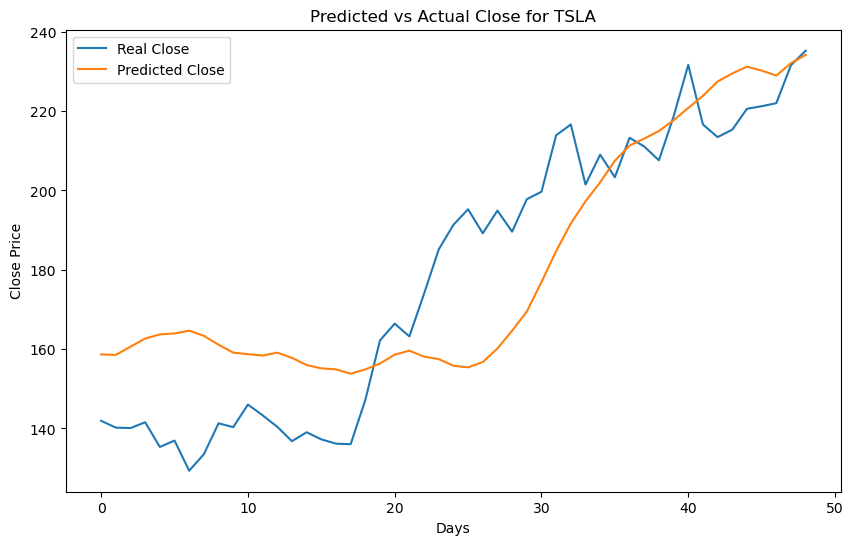

Reloading Tuner from hyperparameter_tuning/WMT_lstm_tuning/tuner0.json


/home/hduser/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/hduser/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best hyperparameters for WMT: {'units_1': 64, 'dropout_1': 0.2, 'units_2': 64, 'dropout_2': 0.30000000000000004, 'learning_rate': 0.0005404919696702361, 'tuner/epochs': 5, 'tuner/initial_epoch': 2, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0000'}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0203 
Best model for WMT - Test Loss: 0.017483755946159363
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


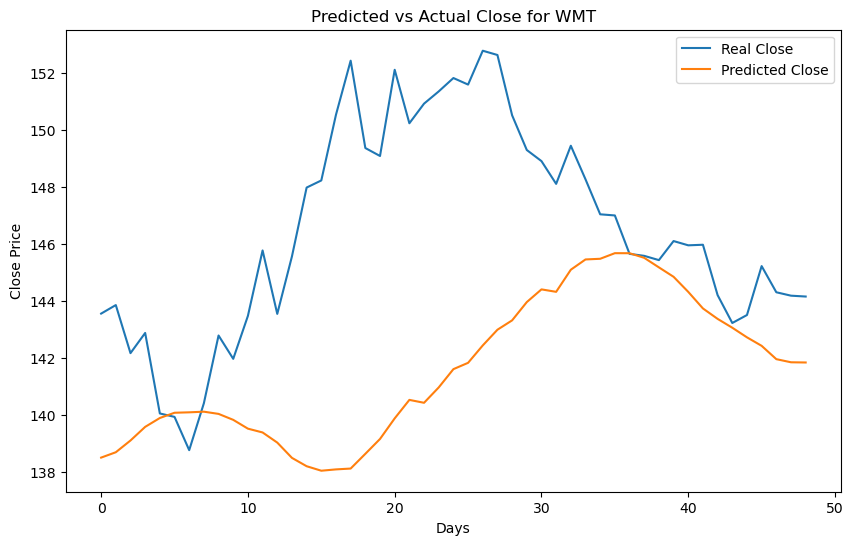

In [54]:
import pandas as pd
import numpy as np
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, to_date

# List of companies you want to analyze
companies = ['BAC', 'DIS', 'PG', 'TSLA', 'WMT']

# Function to create the dataset
def create_dataset(data, time_step=7, prediction_horizon=7):
    X = []
    y = []
    for i in range(len(data) - time_step - prediction_horizon + 1):
        X.append(data[i:(i + time_step)])  # Sequence of 'time_step' values
        y.append(data[(i + time_step + prediction_horizon - 1), 0])  # Target value for 'Close' (next price)
    return np.array(X), np.array(y)

# Function to build the LSTM model with hyperparameters
def build_model(hp):
    model = Sequential()
    
    # Hyperparameter tuning for the first LSTM layer (limit units)
    model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=64, step=32),
                   return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Hyperparameter tuning for the second LSTM layer (limit units)
    model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=64, step=32),
                   return_sequences=False))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Output layer
    model.add(Dense(units=1))
    
    # Hyperparameter tuning for the learning rate (smaller range)
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-3, sampling='log')),
                  loss='mean_squared_error')
    
    return model

# Hyperparameter tuning with Keras Tuner
def tune_hyperparameters(company):
    # Load the company's data
    df_spark = filled_company_data[company]
    df = df_spark.toPandas()

    # Preprocessing
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)  # Set the date as the index of the DataFrame

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[['Close', 'sentiment']].values)

    # Prepare the dataset
    time_step = 7
    prediction_horizon = 7
    X, y = create_dataset(scaled_data, time_step, prediction_horizon)

    # Split the data into training and testing sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Set up the Keras Tuner
    tuner = kt.Hyperband(
        build_model,  # Function to build the model
        objective='val_loss',  # Objective to optimize (minimizing validation loss)
        max_epochs=5,  # Reduced number of epochs for faster testing
        hyperband_iterations=1,  # Reduced number of hyperband iterations for faster results
        directory='hyperparameter_tuning',  # Directory to store results
        project_name=f'{company}_lstm_tuning'
    )

    # Run the hyperparameter search (limit epochs to 5)
    tuner.search(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

    # Get the best model and hyperparameters
    best_model = tuner.get_best_models(num_models=1)[0]
    best_hyperparameters = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

    # Store best hyperparameters for the company
    print(f"Best hyperparameters for {company}: {best_hyperparameters}")
    
    # Save the best model for later use (you can use the model for predictions)
    best_model.save(f"{company}_best_lstm_model.h5")

    # Evaluate the best model on the test set
    test_loss = best_model.evaluate(X_test, y_test)
    print(f"Best model for {company} - Test Loss: {test_loss}")

    # Make predictions with the best model
    predicted_close = best_model.predict(X_test)

    # Inverse the scaling transformation to get the actual predicted 'Close' values
    predicted_close = scaler.inverse_transform(np.hstack((predicted_close, np.zeros((predicted_close.shape[0], 1)))))[:, 0]

    # Inverse scaling for actual 'Close' values from the test set
    actual_close = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1)))))[:, 0]

    # Visualize the results
    plt.figure(figsize=(10, 6))
    plt.plot(actual_close, label='Real Close')
    plt.plot(predicted_close, label='Predicted Close')
    plt.legend()
    plt.title(f'Predicted vs Actual Close for {company}')
    plt.xlabel('Days')
    plt.ylabel('Close Price')
    plt.show()

# Loop through each company to tune the hyperparameters and make predictions
for company in companies:
    tune_hyperparameters(company)


# Storing results to DataBase NO SQL Cassandra

In [53]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit

# Start Spark session
spark = SparkSession.builder \
    .appName("AddCompanyColumn") \
    .config("spark.cassandra.connection.host", "localhost") \
    .getOrCreate()

# List of companies
companies = ['BAC', 'DIS', 'PG', 'TSLA', 'WMT']

# Create an empty DataFrame to combine all the data
final_df = None

# Iterate over the companies and add the 'company' column
for company in companies:
    # Get the data for each company from filled_company_data (assuming filled_company_data is a Spark DataFrame)
    df = filled_company_data[company]  # Here you need to get your DataFrame for each company in Spark
    
    # Convert the pandas DataFrame to a Spark DataFrame
    df_spark = df
    
    # Add the 'company' column with the company's name
    df_spark_with_company = df_spark.withColumn('company', lit(company))
    
    # Union the DataFrame with the final DataFrame
    if final_df is None:
        final_df = df_spark_with_company
    else:
        final_df = final_df.union(df_spark_with_company)

# Show the combined DataFrame
final_df.show(3)


+----------+---------+------------------+------------------+-------+
|      date|sentiment|sentiment_category|             Close|company|
+----------+---------+------------------+------------------+-------+
|2019-12-31|      0.0|           Neutral|35.220001220703125|    BAC|
|2020-01-02|      0.0|           Neutral| 35.63999938964844|    BAC|
|2020-01-03|      0.0|           Neutral|34.900001525878906|    BAC|
+----------+---------+------------------+------------------+-------+
only showing top 3 rows



24/12/11 20:55:26 WARN DAGScheduler: Broadcasting large task binary with size 1021.2 KiB


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit

# Start Spark session
spark = SparkSession.builder \
    .appName("AddCompanyColumn") \
    .config("spark.cassandra.connection.host", "localhost") \
    .getOrCreate()

# Create Cassandra Keyspace
spark.sql("""
    CREATE KEYSPACE IF NOT EXISTS ca2
    WITH replication = {'class': 'SimpleStrategy', 'replication_factor': 1}
""")

# Create a Cassandra table
spark.sql("""
    CREATE TABLE IF NOT EXISTS ca2.results (
        date DATE,
        sentiment FLOAT,
        sentiment_category STRING,
        close DOUBLE,
        company STRING,
        PRIMARY KEY (date, company)
    )
""")

In [ ]:
# Save the combined DataFrame to Cassandra
final_df.write \
    .format("org.apache.spark.sql.cassandra") \  # Specify the Cassandra format
    .option("keyspace", "ca2") \  # Set the Cassandra keyspace name (replace with your actual keyspace)
    .option("table", "results") \  # Set the Cassandra table name (replace with your actual table)
    .mode("append") \  # Append the data to the existing table (use "overwrite" to replace the data)
    .save()  # Execute the write operation

# Stop the Spark session
spark.stop()  # Close the Spark session once the operation is completed
